#### *This juypter book is based on Hands-on Machine Learning with Scikit-Learn & Tensorflow by Aurelien Geron. This is for learning purpose.*
### Autoencoders

Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called codings, without any labelled training data. <br />
Autoencoders represent the features in lower dimensions making them useful wide variety of applications like<br />
<br />1. Dimensionality reduction
<br />2. Feature detectors
<br />3. Unsupervised learning
<br />4. Generate more data that looks very similar to the training data. (Generative models)<br /><br /> 
Autoencoders try to simply copy their inputs to ouputs but we constraint the network in a number of ways and make it difficult for the network to generate the output. This causes the network to find effiecient ways to represent the data. <br /><br />
An autoencoder is composed of two components: 
<br />1. an encoder or recognition network that converts the inputs to an internal representation
<br />2. a decoder or generative network that converts the internal representation to the outputs
<br />The cost function contains a recostruction loss that penalizes the model if the generated outputs are different from the inputs<br />

### PCA using Autoencoder
For example if there are 3 inputs and in the next layer there are two neurons (encoder) and in the final layer there are again three neurons (decoders) as there must be equal number of neurons in the inputs and outputs. In this the 3 inputs must be reduced to 2 neurons and the autoencoder is said to be undercomplete. This constraint causes the autoencoder to extract and represent features in lower dimensions and ignore unimportant features.
<br /><br />If activation functions are **linear** and the cost function in **Mean Squared Error (MSE)**, then autoencoder ends up performing **PCA**.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
from sklearn.preprocessing import StandardScaler

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

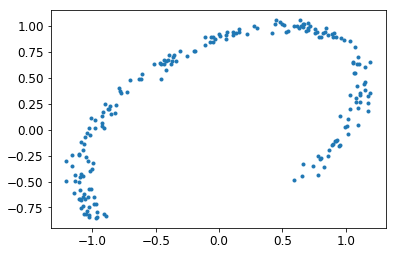

In [2]:
np.random.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
data[:, 1] = np.sin(angles) + 0.7 * noise * np.random.randn(m)/2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
plt.plot(data[:, 0], data[:, 1], '.')
plt.show()

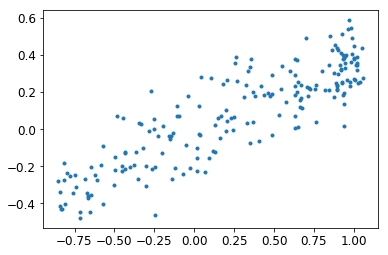

In [3]:
plt.plot(data[:, 1], data[:, 2], '.')
plt.show()

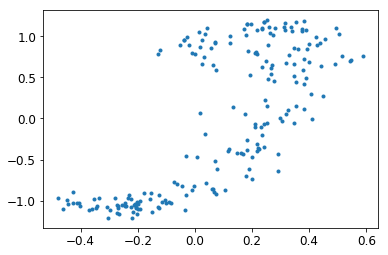

In [4]:
plt.plot(data[:, 2], data[:, 0], '.')
plt.show()

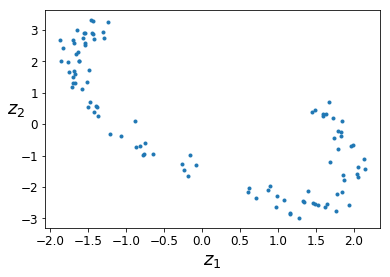

In [5]:
#Normalize the data

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

plt.plot(codings_val[:,1], codings_val[:, 0], ".")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

### Stacked Autoencoders
Autoencoders with multiple hidden layers are called stacked autoencoders or deep autoencoders. Deep autoencoders with high number of hidden layers should not be developed as the encoder with try to map each input to a single data point without extracting any features and may not work in generalized conditions.
<br />In general, stacked autoencoders will have same number of **input units** and **output units**, neurons in **hidden$_1$ layer** and **hidden$_{n-1}$ layer** and so on.

In [36]:
reset_graph()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("E:/GitHub Main/Python-Handson-Projects/datasets/mnist")

from functools import partial

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                        activation = tf.nn.elu, 
                        kernel_initializer = he_init,
                        kernel_regularizer = l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation = None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})  
        print("\r{}".format(epoch), "Train MSE:", loss_train)  
        saver.save(sess, "E:/GitHub Main/Python-Handson-Projects/saved/11-1-my_model_all_layers.ckpt")

Extracting E:/GitHub Main/Python-Handson-Projects/datasets/mnist\train-images-idx3-ubyte.gz
Extracting E:/GitHub Main/Python-Handson-Projects/datasets/mnist\train-labels-idx1-ubyte.gz
Extracting E:/GitHub Main/Python-Handson-Projects/datasets/mnist\t10k-images-idx3-ubyte.gz
Extracting E:/GitHub Main/Python-Handson-Projects/datasets/mnist\t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.0208554
19% Train MSE: 0.0113726
29% Train MSE: 0.0102246
39% Train MSE: 0.00990046
4 Train MSE: 0.0103758


INFO:tensorflow:Restoring parameters from E:/GitHub Main/Python-Handson-Projects/saved/11-1-my_model_all_layers.ckpt


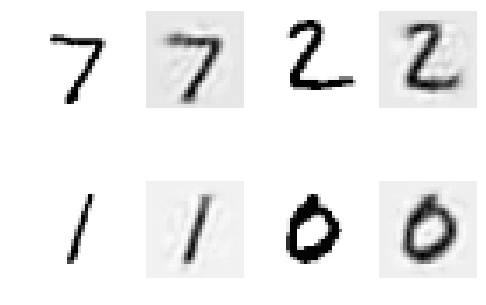

In [39]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 4):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 4, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 4, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
show_reconstructed_digits(X, outputs, "E:/GitHub Main/Python-Handson-Projects/saved/11-1-my_model_all_layers.ckpt")

### Tying Weights

Weights of the decoder layers can be tied to the weights of encoder layers if the autoencoder is symmetrical around the coding layer. This reduces the number of weights in the model by half and helps in speeding up the training process. This also reduces the risk of overfitting the model.
<br />It is common to tie the weights of the encoder and the decoder `(weights_decoder = tf.transpose(weights_encoder))`. Unfortunately this makes it impossible (or very tricky) to use the `tf.layers.dense()` function, so we need to build the Autoencoder manually:

0 Train MSE: 0.0150667
1 Train MSE: 0.0164884
2 Train MSE: 0.0173757
3 Train MSE: 0.0168781
4 Train MSE: 0.0155875
INFO:tensorflow:Restoring parameters from E:/GitHub Main/Python-Handson-Projects/saved/11-2-my_model_all_layers.ckpt


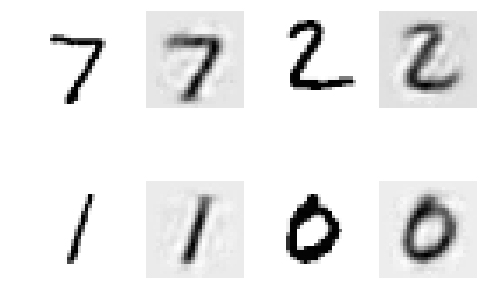

In [42]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="baises1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="baises2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="baises3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="baises4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss


optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "E:/GitHub Main/Python-Handson-Projects/saved/15-2-my_model_all_layers.ckpt")

show_reconstructed_digits(X, outputs, "E:/GitHub Main/Python-Handson-Projects/saved/15-2-my_model_all_layers.ckpt")